In [ ]:
# pip install texthero
# !python -m spacy download en_core_web_lg

In [2]:
# Importing Libraries

import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import texthero as hero

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
con = sqlite3.connect('drive/My Drive/Dataset/Amazon food review/database.sqlite')

In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

In [5]:
filtered_data.shape

(525814, 10)

In [6]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data['Score'].map(partition)

print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data['Score'].unique()

array([1, 0])

In [8]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
...,...,...,...,...,...,...,...,...,...,...
250505,271615,B001E52ZJ4,A34U0B84YB7FL2,Alan D. Roskam,0,0,1,1351209600,Best of the Bunch,Tastes great and full of fiber. The new breakf...
189914,205938,B00005C2M2,A3IVNUHADVJKFA,Krystalyn A Kirschner,0,0,1,1351209600,Perfect Gift,I got these to give out in a goodie bag for th...
517176,559158,B004LLGBQG,A4IL0CLL27Q33,D. Brennan,0,0,0,1351209600,Buyer beware,Nespresso makes GREAT coffee and GREAT machine...
156284,169487,B000NM1BHQ,A2JDXKFZ0PFHKU,James W. Shondel,0,0,0,1351209600,Received broken,I bought these to use as decorative center pie...


In [9]:
sorted_data['Score'].shape

(525814,)

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [12]:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]

In [13]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [23]:
# Creating Bar chart of claim counts
temp = final['Score'].value_counts()/len(final)
fig = px.bar(x= ['Positive', 'Negative'], y= final['Score'].value_counts(),\
             template= 'presentation', text= [f'{round(temp[1]*100, 2)}%', f'{round(temp[0]*100, 2)}%'],\
             title= 'Claim Counts', height= 400, width = 500)

fig.update_traces(marker= dict(color= ['rgb(250, 98, 89)', 'rgb(95, 111, 176)'],\
                               line=dict(color='#000000', width=2), opacity= 0.8)
                 )
fig.show()

In [25]:
# printing some random reviews
random_review = [0, 1000, 1500, 4900, 50000]
for i in random_review:
    print(final['Text'].values[i])
    print("="*100)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had. 

In [50]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [60]:
import nltk
# nltk.download("popular")
stop_words = stopwords.words('english')

In [61]:
len(stop_words)

179

In [62]:
stop_words.append('br')

In [63]:
stop_words.sort()

In [64]:
len(stop_words)

180

In [ ]:
stop_words

In [66]:
words = ['no', 'not']
for i in stop_words:
    if i in words:
        stop_words.remove(i)

In [67]:
len(stop_words)

178

In [ ]:
stop_words

In [83]:
# Combining all the above stundents 
from tqdm import tqdm
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemm = WordNetLemmatizer()

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    sentance = ' '.join(lemm.lemmatize(word) for word in sentnce.split())
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:49<00:00, 1586.42it/s]


In [84]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [101]:
final['cleaned'] = preprocessed_reviews

In [85]:
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec

from time import time
start = time()
w2v_model = Word2Vec(list_of_sentance, min_count=5, size=50, workers=4)
# nlp = Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)
end = time()
print(f'Time for running: {end - start}')

Time for running: 120.29430150985718


In [86]:
w2v_model.wv.most_similar('great')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('terrific', 0.8679184913635254),
 ('good', 0.865554690361023),
 ('fantastic', 0.8597840070724487),
 ('awesome', 0.8422867655754089),
 ('excellent', 0.8371555209159851),
 ('perfect', 0.7907278537750244),
 ('wonderful', 0.7822800278663635),
 ('nice', 0.7504860758781433),
 ('amazing', 0.7234499454498291),
 ('decent', 0.7209404706954956)]

In [89]:
w2v_model.wv.most_similar('tasty')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('delicious', 0.8184243440628052),
 ('yummy', 0.8028247952461243),
 ('satisfying', 0.7848701477050781),
 ('tastey', 0.7839753031730652),
 ('filling', 0.7542163729667664),
 ('flavorful', 0.7090478539466858),
 ('good', 0.6837148070335388),
 ('nice', 0.6750184893608093),
 ('surprisingly', 0.6681901216506958),
 ('nutritious', 0.6380569934844971)]

In [92]:

import gensim

In [94]:
nlp= gensim.models.word2vec.Word2Vec()

In [99]:
final['cleaned']

138706    [witty, little, book, make, son, laugh, loud, ...
138683    [remember, seeing, show, aired, television, ye...
417839    [beetlejuice, well, written, movie, everything...
417859    [twist, rumplestiskin, captured, film, starrin...
417838    [beetlejuice, excellent, funny, movie, keaton,...
                                ...                        
30235     [originally, purchased, chew, veterinarian, de...
250505    [taste, great, full, fiber, new, breakfast, ch...
189914    [got, give, goodie, bag, holiday, couple, extr...
156284    [bought, use, decorative, center, piece, birth...
386211    [product, great, alternative, peanut, butter, ...
Name: cleaned, Length: 364171, dtype: object

In [106]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  29796
sample words  ['witty', 'little', 'book', 'make', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whale', 'india', 'drooping', 'rose', 'love', 'new', 'word', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'aired', 'television', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'song', 'student', 'teaching']


In [107]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 364171/364171 [13:10<00:00, 460.42it/s]


In [108]:
len(sent_vectors)

364171

In [109]:
len(sent_vectors[0])

50

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X = sent_vectors
y = final['Score']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
#SMOTE
from imblearn.over_sampling import SMOTE, ADASYN
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

print(f'Before OverSampling, label 1: {sum(y == 1)}')
print(f'Before OverSampling, label 0: {sum(y == 0)}\n')

print(f'After OverSampling, the shape of X_train: {X_train_res.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_res.shape}\n')

print(f'After OverSampling, label 1: {sum(y_train_res == 1)}')
print(f'After OverSampling, label 0: {sum(y_train_res == 0)}')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Before OverSampling, label 1: 307061
Before OverSampling, label 0: 57110

After OverSampling, the shape of X_train: (429768, 50)
After OverSampling, the shape of y_train: (429768,)

After OverSampling, label 1: 214884
After OverSampling, label 0: 214884


In [124]:
#Model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

In [136]:
def print_results(y_test, y_pred, model='Results:'):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    import scikitplot as skplt
    print(model)
    print(f"Accuracy is {round(accuracy_score(y_test, y_pred), 2)}")
    print(f"\nPrecision-score is {round(precision_score(y_test, y_pred), 2)}")
    print(f"\nRecall-score is {round(recall_score(y_test, y_pred), 2)}")
    print(f"\nF1-score is {round(f1_score(y_test, y_pred), 2)}")
    print(f"\nclassification Report:\n {classification_report(y_test, y_pred)}\n")
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix for {model} Classifier")
    plt.show()

LR
Accuracy is 0.84

Precision-score is 0.97

Recall-score is 0.84

F1-score is 0.9

classification Report:
               precision    recall  f1-score   support

           0       0.50      0.85      0.63     17075
           1       0.97      0.84      0.90     92177

    accuracy                           0.84    109252
   macro avg       0.73      0.84      0.76    109252
weighted avg       0.89      0.84      0.86    109252




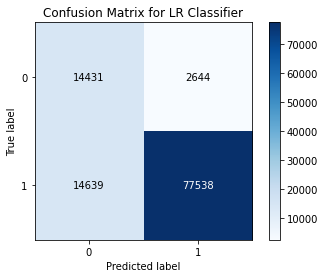

In [137]:
print_results(y_test, y_pred_lr, model= 'LR')

In [129]:
rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

RF
Accuracy is 0.88

Precision-score is 0.94

Recall-score is 0.92

F1-score is 0.93

classification Report:
               precision    recall  f1-score   support

           0       0.60      0.68      0.63     17075
           1       0.94      0.92      0.93     92177

    accuracy                           0.88    109252
   macro avg       0.77      0.80      0.78    109252
weighted avg       0.89      0.88      0.88    109252




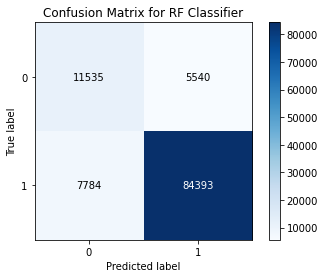

In [130]:
print_results(y_test, y_pred_rf, model= 'RF')